In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import operator

# Load Data

In [3]:
allergies = pd.read_csv('allergies.csv')
careplans = pd.read_csv('careplans.csv')
concepts = pd.read_csv('concepts.csv')
conditions = pd.read_csv('conditions.csv')
encounters = pd.read_csv('encounters.csv')
imaging_studies = pd.read_csv('imaging_studies.csv')
immunizations = pd.read_csv('immunizations.csv')
medications = pd.read_csv('medications.csv')
observations = pd.read_csv('observations.csv')
organizations = pd.read_csv('organizations.csv')
patients = pd.read_csv('patients.csv')
procedures = pd.read_csv('procedures.csv')
providers = pd.read_csv('providers.csv')

# Longitudinal comparison

- After qualitatively looking over the data tables, I decided to explore Massandopolis' disorders as time series data. I wanted to see whether there were sudden increase in prevalence or consistently high prevalence of certain disorders from year to year.
- I will measure by looking at the percentage of patients who has the disease

## Conditions

 - starting with the conditions table and patients table

In [4]:
# change the time when the condition happened to only include years; exclude date and month
conditions.START = conditions.START.str.slice(0,4)
conditions.START = conditions.START.astype(float)
conditions.STOP = conditions.STOP.str.slice(0,4)
conditions.STOP = conditions.STOP.astype(float)

In [5]:
# alter patients table
# get rid of an erroneous entry where DEATHDATE is 2022
patients['DEATHDATE'] = patients['DEATHDATE'].astype(str)
patients = patients[~patients['DEATHDATE'].str.startswith('2022')]

# retain only the year for 'BIRTHDATE' and 'DEATHDATE'
patients.BIRTHDATE = patients.BIRTHDATE.str.slice(0,4)
patients.DEATHDATE = patients.DEATHDATE.str.slice(0,4)

# change year of 'BRITHDATE' and 'DEATHDATE' to float
patients.BIRTHDATE =patients.BIRTHDATE.astype(float)
patients.DEATHDATE = patients.DEATHDATE.replace('nan', np.nan)
patients.DEATHDATE = patients.DEATHDATE.astype(float)

In [6]:
# sort conditions table's 'DESCRIPTION' by number of occurences
conditions['DESCRIPTION'].value_counts()

Viral sinusitis (disorder)                                               16893
Acute viral pharyngitis (disorder)                                        9389
Acute bronchitis (disorder)                                               7686
Normal pregnancy                                                          6079
Drug overdose                                                             4710
Body mass index 30+ - obesity (finding)                                   4143
Anemia (disorder)                                                         2979
Chronic pain                                                              2891
Prediabetes                                                               2871
Chronic intractable migraine without aura                                 2857
Impacted molars                                                           2838
Hypertension                                                              2247
Otitis media                                        

**seems that some viral respiratory diseases are really common throughout the history of Massandopolis, but I want to see the number of occurrences each year**


In [7]:
# combine patients and conditions table
pat_con = pd.merge(conditions[['START', 'STOP', 'PATIENT', 'DESCRIPTION']], 
                   patients[['Id', 'BIRTHDATE', 'DEATHDATE']], 
                   left_on='PATIENT', right_on='Id', how='left')

# replace 'STOP' date with 'DEATHDATE' if 'STOP' date is nan
pat_con.loc[pat_con['STOP'].isna(), 'STOP'] = pat_con.loc[pat_con['STOP'].isna(), 'DEATHDATE']

- seems that there are two types of conditions from exploring the conditions table. Some conditions has a 'STOP' date, while some don't. I will use two methods to explore the occurrences of the most common conditions for each year. 
- Ultimately, conditions table is not reliable. For example, 'Drug Overdose' has a 'START' date but does not have a 'STOP' date, which doesn't make sense since drug overdose is not a chronic condition. The following will be for exploratory purpose.

In [8]:

# for the 30 most common conditions, i wanted to see the number of occurrences each year
con_result = pd.DataFrame()
stop_date = []
for int_con in pat_con.loc[:,'DESCRIPTION'].value_counts().index[0:30]:
    
    # how many patients start having this condition each year
    dis_start = pat_con.loc[pat_con['DESCRIPTION'] == int_con, 
                                ['START','PATIENT']].groupby('START').count()
    
    # how many patients stop having this condition each year
    dis_end = pat_con.loc[pat_con['DESCRIPTION'] == int_con,
                            ['STOP','PATIENT']].groupby('STOP').count()
    
    # calculate what the cumulative total of patients with the condition each year
    # add to the results table
    dis_yearly_gross = pd.concat([dis_start, dis_end], axis = 1, sort = True)
    dis_yearly_gross.columns = ['dis_start', 'dis_end']
    dis_yearly_gross = dis_yearly_gross.fillna(0)
    dis_yearly_gross[int_con] = dis_yearly_gross['dis_start'] - dis_yearly_gross['dis_end']
    
    #if the original conditions table had no 'STOP' date for this condition, add marker 
    if sum(conditions.loc[conditions['DESCRIPTION'] == int_con,'STOP'].notna()) == 0:
        stop_date.append(0)
    else:
        stop_date.append(1)
        
    con_result = pd.concat([con_result, dis_yearly_gross[int_con].cumsum()], axis = 1)
    

# indicate wether each condition had 'STOP' dates, has 'STOP' date is indicated by 1,
# otherwise 0
con_result = pd.concat([pd.DataFrame([stop_date], columns = con_result.columns,
                        index = ['stop_date']), con_result])

In [9]:
# calculate the population for each year
# count the number of patients who was born for each year
birth_n = patients[['Id', 'BIRTHDATE']].groupby('BIRTHDATE').count()

# count the number of patients who died for each year
death_n = patients[['Id', 'DEATHDATE']].groupby('DEATHDATE').count()

# calculate the population
population = pd.concat([birth_n, death_n], axis = 1, sort = True)
population.columns = ['birth_n', 'death_n']
population = population.fillna(0)
# what's the increase or decrease in population for each year
population['net'] = population['birth_n'] - population['death_n']
# what's the total population for each year
population['population'] = population['net'].cumsum()
population

,birth_n,death_n,net,population
1908.0,11,0.0,11.0,11.0
1909.0,22,0.0,22.0,33.0
1910.0,44,0.0,44.0,77.0
1911.0,22,0.0,22.0,99.0
1912.0,44,1.0,43.0,142.0
1913.0,99,1.0,98.0,240.0
1914.0,77,0.0,77.0,317.0
1915.0,66,2.0,64.0,381.0
1916.0,66,1.0,65.0,446.0
1917.0,33,4.0,29.0,475.0


In [10]:
con_result

,Viral sinusitis (disorder),Acute viral pharyngitis (disorder),Acute bronchitis (disorder),Normal pregnancy,Drug overdose,Body mass index 30+ - obesity (finding),Anemia (disorder),Chronic pain,Prediabetes,Chronic intractable migraine without aura,...,Acute bacterial sinusitis (disorder),Concussion with no loss of consciousness,Sinusitis (disorder),Seizure disorder,History of single seizure (situation),Whiplash injury to neck,Sprain of wrist,Diabetes,Child attention deficit disorder,Hypertriglyceridemia (disorder)
stop_date,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1909.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1910.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1911.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN
1912.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1913.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN
1914.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN
1915.0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN
1916.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1917.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN


**the result shows for each condition, how many cases there are for each year. Some are chronic conditions like chronic pain and obesity, which doesn't have a 'STOP' date, so each year the prevalence of the condition accumulates and add up cases from previous to become high prevalence. Some are not chronic conditions and has 'STOP' date. Like viral sinusitis, which has the same 'STOP' year as the 'START' year, so value is showing the prevalence of the condition for that year only.**

In [11]:
# 2018 prevalence of conditions
con_result.iloc[-2,:].sort_values(ascending = False)

Drug overdose                                     3086.0
Body mass index 30+ - obesity (finding)           2233.0
Chronic pain                                      1942.0
Chronic intractable migraine without aura         1938.0
Impacted molars                                   1897.0
Prediabetes                                       1355.0
Hypertension                                      1248.0
Anemia (disorder)                                 1159.0
Chronic sinusitis (disorder)                       963.0
Miscarriage in first trimester                     889.0
Body mass index 40+ - severely obese (finding)     570.0
Hyperlipidemia                                     472.0
History of single seizure (situation)              337.0
Seizure disorder                                   337.0
Diabetes                                           287.0
Hypertriglyceridemia (disorder)                    272.0
Polyp of colon                                     104.0
Normal pregnancy               

**if we look at 2018, the population is 5003, but there are over 3086 patients who had drug overdose. While I want to say that's what Massandopoleans are worried about, that's not a correct assessment. This error is caused by the lack of 'STOP' date for this condition. Using the 'DEATHDATE' of patients as 'STOP' date does not help. Only results that have 'STOP' dates can be trusted.**

**Using the 'DEATHDATE' of patients as 'STOP' date does help in some cases. Some conditions have 'STOP' dates like anemia. However, when a patient dies, there's no 'STOP' dates added for his/her conditions, so using 'DEATHDATE' as 'STOP' date gives us the correct results.**

**Result for drug overdose cannot be trusted since it doesn't have a 'STOP' date, neither does obesity, chronic pain, migraine, and etc. While we can trust the results for conditions that have a 'STOP' date, further investigation is needed for conditions without a 'STOP' date. They are still worth looking into though, since the top 2 (drug overdose and obesity) are pretty high in prevalence. They will be explored in later sections** 

### anemia

In [12]:
# showing the number of cases in 2018 for conditions that have a 'STOP' date 
con_result.loc[:, con_result.loc['stop_date',:] == 1].iloc[-2]

Viral sinusitis (disorder)                    20.0
Acute viral pharyngitis (disorder)             8.0
Acute bronchitis (disorder)                    3.0
Normal pregnancy                              95.0
Anemia (disorder)                           1159.0
Otitis media                                  24.0
Streptococcal sore throat (disorder)           1.0
Chronic sinusitis (disorder)                 963.0
Sprain of ankle                                7.0
Polyp of colon                               104.0
Acute bacterial sinusitis (disorder)           4.0
Concussion with no loss of consciousness       5.0
Sinusitis (disorder)                           6.0
Whiplash injury to neck                        1.0
Sprain of wrist                                3.0
Child attention deficit disorder              77.0
Name: 2018.0, dtype: float64

**anemia is the most prevalent**

In [13]:
con_result['Anemia (disorder)'].iloc[1:]

1909.0       NaN
1910.0       NaN
1911.0       NaN
1912.0       NaN
1913.0       NaN
1914.0       NaN
1915.0       NaN
1916.0       NaN
1917.0       NaN
1918.0       NaN
1919.0       NaN
1920.0       NaN
1921.0       NaN
1922.0       NaN
1923.0       NaN
1924.0       NaN
1925.0       NaN
1926.0       NaN
1927.0       1.0
1928.0       3.0
1929.0       4.0
1930.0       NaN
1931.0       7.0
1932.0      10.0
1933.0      13.0
1934.0      16.0
1935.0      18.0
1936.0      21.0
1937.0      29.0
1938.0      44.0
           ...  
1990.0    1271.0
1991.0    1279.0
1992.0    1290.0
1993.0    1296.0
1994.0    1302.0
1995.0    1315.0
1996.0    1323.0
1997.0    1324.0
1998.0    1307.0
1999.0    1303.0
2000.0    1306.0
2001.0    1315.0
2002.0    1297.0
2003.0    1295.0
2004.0    1299.0
2005.0    1313.0
2006.0    1287.0
2007.0    1267.0
2008.0    1246.0
2009.0    1235.0
2010.0    1227.0
2011.0    1216.0
2012.0    1210.0
2013.0    1208.0
2014.0    1181.0
2015.0    1178.0
2016.0    1174.0
2017.0    1173

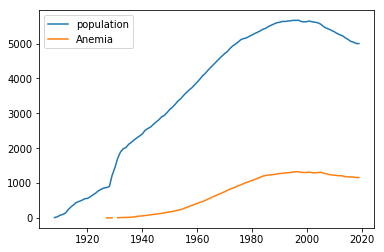

In [14]:
# plot showing population and number of anemia throughout the years
plt.plot(population['population'], label = 'population')
plt.plot(con_result['Anemia (disorder)'].iloc[1:], label = 'Anemia')
plt.legend()

plt.show()
plt.close()

**anemia has the highest number of occurrences in 2018 out of all the conditions that have a 'STOP' date. ~20% of all patients was living with anemia in 2018. graph also show similar trend for previous years. This is a selection of sick patients, I can't say that it's representative of the entire population of Massandopolis. Therefore, I can't say that Massandopoleans are worried about anemia for now.** 

## Drug Overdose

**explore the number of 'Drug overdose' encounters for each year**

In [15]:
# retain year for START and STOP columns in encounters table
encounters.START = encounters.START.str.slice(0,4)
encounters.START = pd.to_numeric(encounters["START"])
encounters.STOP = encounters.STOP.str.slice(0,4)
encounters.STOP = pd.to_numeric(encounters["STOP"])

In [16]:
# obtain number of patients with a encounter of interest for the top 60 encounters for each year
enc_result = pd.DataFrame()
for int_enc in encounters.loc[:,'REASONDESCRIPTION'].value_counts().index[0:60]:
    
    sub_enc = encounters.loc[encounters['REASONDESCRIPTION']==int_enc, ['START', 'PATIENT']]
    # get rid of duplicates where patients has multiple visit for the encounter of interest
    sub_enc = sub_enc.drop_duplicates()
    
    # count the number of unique patients with the encounter of interest each year
    enc_count = sub_enc.groupby('START').count()
    enc_result = pd.concat([enc_result, enc_count['PATIENT'].rename(int_enc)], axis = 1)
    


In [17]:
enc_result

,Normal pregnancy,Drug overdose,Hyperlipidemia,Viral sinusitis (disorder),Acute viral pharyngitis (disorder),Acute bronchitis (disorder),Child attention deficit disorder,Chronic pain,Chronic intractable migraine without aura,Impacted molars,...,Familial Alzheimer's disease of early onset (disorder),Injury of medial collateral ligament of knee,Gout,Idiopathic atrophic hypothyroidism,Non-small cell lung cancer (disorder),Non-small cell carcinoma of lung TNM stage 1 (disorder),Injury of anterior cruciate ligament,Tubal pregnancy,Polyp of colon,Major depression single episode
START,,,,,,,,,,,,,,,,,,,,,
1909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1910,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1911,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1912,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1913,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1915,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1916,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1917,NaN,NaN,NaN,3.0,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# highest reason for the encounter in each year besides normal pregnancy
enc_result.drop(['Normal pregnancy'], axis = 1).idxmax(axis =1)
#enc_result.idxmax(axis = 1)

START
1909                                 Otitis media
1910           Acute viral pharyngitis (disorder)
1911                             Seizure disorder
1912                  Acute bronchitis (disorder)
1913         Acute bacterial sinusitis (disorder)
1914                             Childhood asthma
1915                             Seizure disorder
1916                                 Otitis media
1917                                 Otitis media
1918                                 Otitis media
1919                             Seizure disorder
1920                  Acute bronchitis (disorder)
1921         Acute bacterial sinusitis (disorder)
1922                             Seizure disorder
1923                   Viral sinusitis (disorder)
1924                  Acute bronchitis (disorder)
1925                                 Otitis media
1926                             Seizure disorder
1927         Acute bacterial sinusitis (disorder)
1928                             Seizure dis

**besides 'normal pregnancy', 'drug overdose' is the most reasons for an encounter starting from the 2000.**

In [19]:
# count the number of patients with encounters each year
enc_n = encounters[['PATIENT', 'START']].drop_duplicates()
enc_n = enc_n.groupby('START').count()



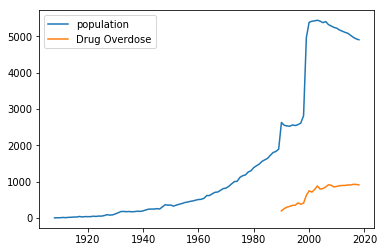

In [20]:
# plot showing population and number of patients who had drug overdose throughout the years
plt.plot(enc_n[:-1], label = 'population')
plt.plot(enc_result['Drug overdose'].iloc[1:-1], label = 'Drug Overdose')
plt.legend()
plt.show()
plt.close()

**Since the 2000's, drug overdose makes up about ~15-18% of total encounter each year. Again, I can't say that drug overdose would cause an alarm in Massandopolis. Need more statistics on the general population.**

## OBESITY

Question I want answered:
**for each year, what percent of the patient who had BMI measured is considered obese?**

In [21]:
# retain year for DATE columns in observations table
observations.DATE = observations.DATE.str.slice(0,4)
observations.DATE = pd.to_numeric(observations["DATE"])


In [22]:
int_obs =  observations.loc[:,'DESCRIPTION'].value_counts().index[6]
int_obs

'Body Mass Index'

In [23]:
# count only the last BMI for each patient for each year
rel_index = observations.loc[observations['DESCRIPTION'] == int_obs, ['DATE', 'PATIENT']].drop_duplicates(keep='last').index
bmi_data = observations.loc[rel_index, :]

In [24]:
bmi_data['VALUE'] = bmi_data['VALUE'].astype(float)

In [25]:
# bmi level > 30 is abnormal, considered obese
bmi_data['obese'] = bmi_data['VALUE'] > 30

In [26]:
# number of patients at the end of the year who has done a bmi measure for each year
bmi_n = bmi_data[['DATE', 'obese']].groupby('DATE').count()
# number of obese patients each year
obese_pat = bmi_data.loc[bmi_data['obese'] == True, ['DATE', 'obese']].groupby('DATE').count()

bmi_pop = pd.concat([bmi_n['obese'].rename('bmi_n'), obese_pat], axis = 1)
bmi_pop = bmi_pop.fillna(0)

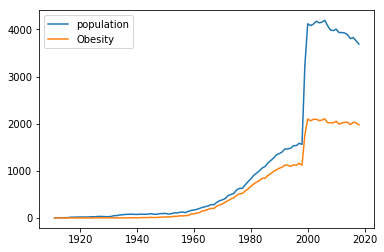

In [27]:
# plot showing population and number of obese throughout the years
plt.plot(bmi_pop['bmi_n'][:-1], label = 'population')
plt.plot(bmi_pop['obese'][:-1], label = 'Obesity')
plt.legend()
plt.show()
plt.close()

**from 2000 - present, the total number of patients who had BMI measured is around ~4000. Of those patients, ~2000 of them are considered obese. Therefore, about half of the patients who had BMI measured are considered obese**

## Other Observations

**I want to see the same graph for different observations.**

In [28]:
def percent_plot(obs_ind, normal_val):
    int_obs =  observations.loc[:,'DESCRIPTION'].value_counts().index[obs_ind]
    rel_index = observations.loc[observations['DESCRIPTION'] == int_obs, ['DATE', 'PATIENT']].drop_duplicates(keep='last').index
    sub_data = observations.loc[rel_index, :]
    sub_data['VALUE'] = sub_data['VALUE'].astype(float)
    
    # create new column to record whether VALUE is above normal range
    sub_data[int_obs] = sub_data['VALUE'] > normal_val
    
    # count by year how many of this measurement was taken
    bmi_n = sub_data[['DATE', int_obs]].groupby('DATE').count()
    
    # number of patients with above normal range measurement each year
    obese_pat = sub_data.loc[sub_data[int_obs] == True, ['DATE', int_obs]].groupby('DATE').count()
    
    # fill in na with zeros
    bmi_pop = pd.concat([bmi_n[int_obs].rename('total_n'), obese_pat], axis = 1)
    bmi_pop = bmi_pop.fillna(0)
    
    #import pdb; pdb.set_trace()
    # plot 
    plt.plot(bmi_pop['total_n'][:-1], label = 'population')
    plt.plot(bmi_pop[int_obs][:-1], label = int_obs)
    plt.legend()
    plt.show()
    plt.close()

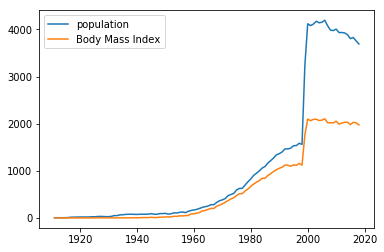

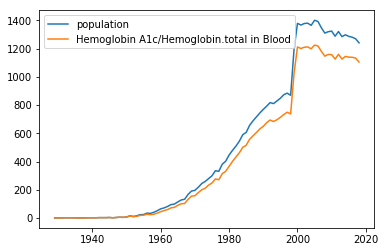

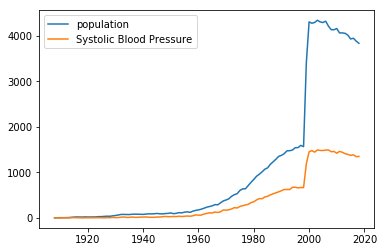

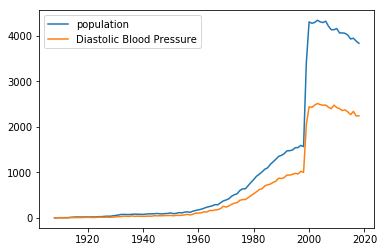

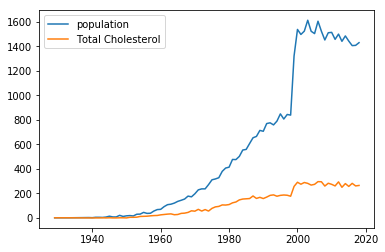

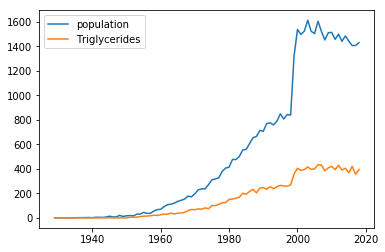

In [29]:
## obesity
percent_plot(6, 30)
## prediabetic or diabetic
percent_plot(19, 5.7)
## systolic
percent_plot(1, 130)
## diastolic
percent_plot(2, 80)
## total cholesterol
percent_plot(18, 200)
## lipids, triglyceride
percent_plot(16, 150)


- obesity is shown as before, almost half of the patients are considered obese. 
- prediabetic or diabetic is measured with Hemoglobin A1c. a level higher than 5.7 is considered prediabetic. For patients who has that measurement, which is not many, almost all of them are prediabetic. This is not representative of the whole population or even the patient population because only about 1600 patients out of about 5000 patients have this measurement since 2000. 
- systolic blood pressure higher than 130 or diastolic blood pressure higher than 80 are considered stage 1 high blood pressure. While 1 in 4 are considered to have high blood pressure according to systolic, 2 in s4 are considered to have high blood pressure according to diastolic for those that have these measurements. 
- cholesterol and triglyceride are measures of level of lipids in blood. The population doesn't seem to have high blood lipid. 

# Summary

Ultimately we don't know how representative this selection of patient is of the general population. Those that seek out medical attention tend to be sicker. Keeping that in mind, there are still some insight that I learned from this dataset. 

we can see from this population of patients that there are many cases of anemia. About 1 in 5 patients are living with anemia in the 2000's. 

Drug overdose could also be a problem. Of the patients with encounters in the 2000's, about 15-18% are admitted for drug overdose.

BMI is observed for almost all patients, and half of those patients has BMI > 30 in the 2000's, which indicates obesity. Those that have measurement for diabetes through Hemoglobin A1c are mostly prediabetic at least. However, only ~1400 out of ~5000 patients had those measurements each year since 2000. If this measure was done for everyone, this may give more insight into the diabetes status of Massandopolis. Diastolic and systolic pressure also indicate a high percentage of high blood pressure. Over half of the patients has high diastolic blood pressure. These diseases are related. It seems that the patients in Massandopolis is suffering from obesity and related issues.

On a side note, the treatment for all cases of viral sinusitis right now is a combination of medications that treat for bacterial sinusitis. While this is not something that would alarm the residents of Massandopolis since there is no outbreak of antibiotic resistent bacterial infection, this could become a problem later. 